In [1]:
import torch
from torchvision import transforms, datasets, models
import torch.nn as nn
import numpy as np
import cv2
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
train_data_path = 'data/train'
val_data_path = 'data/validation'

# Define transforms for the training data and testing data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # rescale the image
        transforms.RandomHorizontalFlip(), # randomly flip image horizontally
        transforms.RandomRotation(10), # randomly rotate image
        transforms.ToTensor(), # convert the image to a Tensor
        transforms.Normalize([0.485, 0.456, 0.406], # normalize image for pre-trained model
                                [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256), # rescale the image
        transforms.CenterCrop(224), # crop image
        transforms.ToTensor(), # convert the image to a Tensor
        transforms.Normalize([0.485, 0.456, 0.406], # normalize image for pre-trained model
                                [0.229, 0.224, 0.225])
    ]),
}

train_dataset = datasets.ImageFolder(train_data_path, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_data_path, transform=data_transforms['validation'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 32, shuffle=True)
# Dataloader iterators, make sure to shuffle

print(train_dataset.class_to_idx)
    

{'damage': 0, 'no_damage': 1}


In [3]:
model = models.resnet50(pretrained=True)
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, 2),
                                    nn.LogSoftmax(dim=1))


# If GPU is available, use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

c:\Users\zhuoq\anaconda3\envs\tensorflow2.6.0\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zhuoq\anaconda3\envs\tensorflow2.6.0\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Train the model
epochs = 20
for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    accuracy = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass
        loss.backward()
        # Perform optimization
        optimizer.step()
        # Update train loss
        train_loss += loss.item()*data.size(0)
    # Calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    # Print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))
    # Validation
    model.eval()
    for batch_idx, (data, target) in enumerate(val_loader):
        # Move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # Forward pass
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss 
        val_loss += loss.item()*data.size(0)
        # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy += torch.mean(correct_tensor.type(torch.FloatTensor))
    # Calculate average losses
    val_loss = val_loss/len(val_loader.dataset)
    accuracy = accuracy/len(val_loader)
    # Print training/validation statistics 
    print('Epoch: {} \tValidation Loss: {:.6f} \tAccuracy: {:.2f}%'.format(
        epoch+1, 
        val_loss,
        accuracy*100
        ))
    # Save model
    if accuracy > 0.945:
        torch.save(model.state_dict(), 'model.pt')
        break

Epoch: 1 	Training Loss: 0.439450
Epoch: 1 	Validation Loss: 0.261680 	Accuracy: 90.08%
Epoch: 2 	Training Loss: 0.337737
Epoch: 2 	Validation Loss: 0.234696 	Accuracy: 89.68%
Epoch: 3 	Training Loss: 0.307795
Epoch: 3 	Validation Loss: 0.196548 	Accuracy: 91.47%
Epoch: 4 	Training Loss: 0.289553
Epoch: 4 	Validation Loss: 0.204169 	Accuracy: 91.52%
Epoch: 5 	Training Loss: 0.282004
Epoch: 5 	Validation Loss: 0.179647 	Accuracy: 92.11%
Epoch: 6 	Training Loss: 0.279996
Epoch: 6 	Validation Loss: 0.173057 	Accuracy: 93.06%
Epoch: 7 	Training Loss: 0.278709
Epoch: 7 	Validation Loss: 0.173617 	Accuracy: 92.11%
Epoch: 8 	Training Loss: 0.262458
Epoch: 8 	Validation Loss: 0.166495 	Accuracy: 93.15%
Epoch: 9 	Training Loss: 0.247219
Epoch: 9 	Validation Loss: 0.176056 	Accuracy: 92.56%
Epoch: 10 	Training Loss: 0.274362
Epoch: 10 	Validation Loss: 0.155469 	Accuracy: 93.30%
Epoch: 11 	Training Loss: 0.247554
Epoch: 11 	Validation Loss: 0.169131 	Accuracy: 92.46%
Epoch: 12 	Training Loss: 0.

In [7]:
# Test the model
test_data_path = 'data/test'
test_dataset = datasets.ImageFolder(test_data_path, transform=data_transforms['validation'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=True)
model.state_dict(torch.load('model.pt'))
model.eval()
accuracy = 0.0
error_count = 0
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    _, pred = torch.max(output, dim=1)
    for i in range(len(target)):
        print(test_loader.dataset.imgs[i][0].split('/')[-1],
              "Pre Res:","damage" if pred[i] == 1 else "no_damage", 
              "Actul Res:","damage" if target[i] == 1 else "no_damage")
        if pred[i] != target[i]:
            error_count += 1
            print("Error Prediction")
    
    correct_tensor = pred.eq(target.data.view_as(pred))
    accuracy += torch.mean(correct_tensor.type(torch.FloatTensor))
accuracy = accuracy/len(test_loader)
error_rate = error_count/len(test_loader.dataset)
print('Test Accuracy: {:.2f}%'.format(accuracy*100), "Error Rate: {:.2f}%".format(error_rate*100))


test\damage\-93.548123_30.900623.jpeg Pre Res: damage Actul Res: damage
test\damage\-93.560128_30.894917.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.578271_30.779923999999998.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.590598_30.694956.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.604017_30.793719.jpeg Pre Res: damage Actul Res: damage
test\damage\-93.6141_30.754263.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.618483_30.730039.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.65613_30.076164000000002.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.658785_30.206929.jpeg Pre Res: damage Actul Res: damage
test\damage\-93.659161_30.202384999999996.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.65936500000001_30.138793.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.659805_30.138094.jpeg Pre Res: no_damage Actul Res: no_damage
test\damage\-93.660431_30.20485.jpeg Pre Res: dama

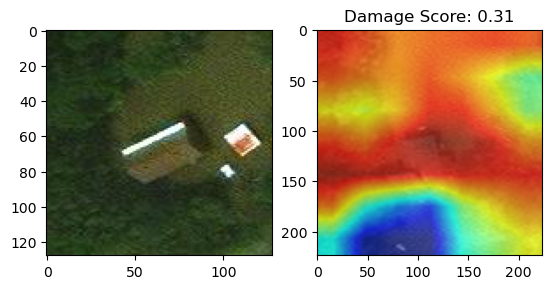

In [19]:
#define Grad-CAM
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.target_layer = dict([*self.model.named_modules()])[layer_name]
        self.gradients = None
        self.target_value = None  # Added
        self.target_layer.register_forward_hook(self.save_gradient)
        self.target_layer.register_forward_hook(self.save_value)  # Added

    def save_gradient(self, module, input, output):
        self.gradients = output

    def save_value(self, module, input, output):  # Added
        self.target_value = output

    def __call__(self, inputs, index=None):
        outputs = self.model(inputs)
        if index is None:
            index = torch.argmax(outputs, 1)
        one_hot = torch.zeros((1, outputs.size()[-1]), dtype=torch.float32)
        one_hot[0][index] = 1
        one_hot = one_hot.requires_grad_().to(device)
        one_hot = torch.sum(one_hot * outputs)
        one_hot.backward(retain_graph=True)
        grad_values = self.gradients[0].cpu().data.numpy()
        target = self.target_value[0].cpu().data.numpy()  # Modified
        weights = np.mean(grad_values, axis=(1, 2))
        cam = np.zeros(target.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam
class DamgeScore:
    def __init__(self, model,layer_name):
        self.grad_cam = GradCAM(model, layer_name)
    def score(self, image_tensor):
        cam = self.grad_cam(image_tensor)
        damge_score = np.mean(cam)
        return damge_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
damge_score = DamgeScore(model, 'layer4')
grad_cam = GradCAM(model, 'layer4')

# 4. visualize
def visualize(image_path, cam):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # resize the image to (224,224,3)
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

'''
# visualize all test images and save in outputs folder
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    _, pred = torch.max(output, dim=1)
    for i in range(len(target)):
        img_path = test_loader.dataset.imgs[i][0]
        print(img_path)
        cam = grad_cam(data[i].unsqueeze(0), target[i])
        cam = cv2.resize(cam, (224, 224))
        cam = visualize(img_path, cam)
        score = damge_score.score(data[i].unsqueeze(0))
        plt.figure()
        plt.subplot(121)
        plt.imshow(plt.imread(img_path))
        plt.subplot(122)
        plt.imshow(cam)
        plt.title("Damage Score: {:.2f}".format(score))
        plt.show()
        #保存图片到本地outputs文件夹
        plt.imsave('outputs\\' + img_path.split('\\')[-1], cam)
'''
#visualize one image
score = []
for img, label in test_loader:
    if label[0] == 0:
        img = img.requires_grad_().to(device)  # 2. Move img to the appropriate device
        cam = grad_cam(img)
        score = damge_score.score(img)
        vis = visualize(test_dataset.imgs[1][0], cam)  # 获取图片路径
        plt.figure()
        plt.subplot(121)
        plt.imshow(plt.imread(test_dataset.imgs[0][0]))
        plt.subplot(122)
        plt.imshow(vis)
        plt.title("Damage Score: {:.2f}".format(score))
        plt.show()
        break



